In [271]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.autograd.functional as F

## Declare the variables

In [272]:
# camera Pose 4x4
T_cw = np.array([[1,0,0,1],
                 [0,1,0,1],
                 [0,0,1,1],
                 [0,0,0,1]])
# homogenous mu_w
mu_w = np.array([2,3,4,1])

cov_3D = np.array([[1,2,3],
                   [2,4,5],
                   [3,5,9]])

# camera Pose 4x4
T_cw_tensor = torch.from_numpy(T_cw).float().requires_grad_(True)
# homogenous mu_w
mu_w_tensor = torch.from_numpy(mu_w).float().requires_grad_(True)

cov_3D_tensor = torch.from_numpy(cov_3D).float().requires_grad_(True)

In [273]:
def Jacobian_pi_func_tensor(v):

    a = torch.stack([
    torch.cat([torch.tensor([1., 0.]), -v[0:1]/v[2:3]]),
    torch.cat([torch.tensor([0., 1.]), -v[1:2]/v[2:3]]),
    ])
    
    a = a/v[2:3]
    return a

In [200]:
import torch
import math

def se3_exp(xi):
    """
    Convert 6D twist xi (linear first, then angular) to SE(3) matrix.
    Input: xi = [v_x, v_y, v_z, ω_x, ω_y, ω_z]
    Output: 4x4 SE(3) transformation matrix T.
    """
    assert xi.shape[-1] == 6
    v, omega = xi[..., :3], xi[..., 3:]  # Split into linear and angular
    
    # Compute [ω]× (skew-symmetric matrix)
    omega_skew = torch.zeros(*xi.shape[:-1], 3, 3, device=xi.device)
    omega_skew[..., 0, 1] = -omega[..., 2]
    omega_skew[..., 0, 2] =  omega[..., 1]
    omega_skew[..., 1, 0] =  omega[..., 2]
    omega_skew[..., 1, 2] = -omega[..., 0]
    omega_skew[..., 2, 0] = -omega[..., 1]
    omega_skew[..., 2, 1] =  omega[..., 0]
    
    theta = torch.norm(omega, dim=-1, keepdim=True)  # Rotation angle ||ω||
    I = torch.eye(3, device=xi.device).expand_as(omega_skew)
    
    # Handle small angles (avoid division by zero)
    small_angle = theta.squeeze(-1) < 1e-10
    sin_theta = torch.sin(theta)
    cos_theta = torch.cos(theta)
    
    # Compute rotation R (Rodrigues formula)
    A = torch.where(
        small_angle.unsqueeze(-1).unsqueeze(-1),
        I + omega_skew,  # R ≈ I + [ω]× when θ ≈ 0
        I + (sin_theta / theta) * omega_skew + 
            ((1 - cos_theta) / theta**2) * (omega_skew @ omega_skew)
    )
    
    # Compute translation t
    B = torch.where(
        small_angle.unsqueeze(-1).unsqueeze(-1),
        I + 0.5 * omega_skew,  # V ≈ I + 0.5[ω]× when θ ≈ 0
        I + ((1 - cos_theta) / theta**2) * omega_skew +
            ((theta - sin_theta) / theta**3) * (omega_skew @ omega_skew)
    )
    t = (B @ v.unsqueeze(-1)).squeeze(-1)
    
    # Construct SE(3) matrix
    T = torch.zeros(*xi.shape[:-1], 4, 4, device=xi.device)
    T[..., :3, :3] = A  # Rotation
    T[..., :3, 3] = t   # Translation
    T[..., 3, 3] = 1     # Homogeneous coordinate
    return T

In [241]:
def hat_operator(v):
	'''
	Hat operator
	'''
	return np.array([[0    ,-v[2],  v[1]],
                     [v[2] ,    0, -v[0]],
                     [-v[1], v[0],    0]])

## Func for mu_I i.e. 2D Mean in the image plane

In [274]:
def func_MU_I(vec):
    """
    vec is a 6D vector with [translation , rotation ]
    """
    I43 = torch.eye(4,3,requires_grad=True, dtype=torch.float32)
    I34 = torch.eye(3,4,requires_grad=True, dtype=torch.float32)
    
    zero = torch.zeros((1), requires_grad=True, dtype=torch.float32)

    # Construct hat operator matrix for vec, we cal it xi
    xi = torch.stack([
    torch.stack([torch.tensor(0.0), -vec[5],  vec[4],  vec[0]]),
    torch.stack([vec[5],  torch.tensor(0.0), -vec[3],  vec[1]]),
    torch.stack([-vec[4], vec[3],  torch.tensor(0.0),  vec[2]]),
    torch.zeros(4)  # Last row
    ])
    xi.requires_grad_(True)
    print("xi: \n",xi)

    # Get the SE(3) Matrix This is the true value of matrix exponential
    T_cw = torch.linalg.matrix_exp(xi)    
    print('Expm True value T_cw: \n', T_cw)

    # Lets 1st order Approximate it
    # T_cw = torch.eye(4,4, requires_grad=True, dtype=torch.float32)+ xi
    # print('Expm 1st order Approx value T_cw: \n', T_cw)

    # Lets 2nd order Approximate it
    # T_cw = torch.eye(4,4, requires_grad=True, dtype=torch.float32)+ xi + 0.5*torch.matmul(xi,xi) 
    # print('Expm 2nd order Approx value T_cw: \n', T_cw)

    # Lets 3rd order Approximate it
    # T_cw = torch.eye(4,4, requires_grad=True, dtype=torch.float32)+ xi + 0.5*torch.matmul(xi,xi) + (1/6)*torch.matmul(xi,torch.matmul(xi,xi))
    # print('Expm 3rd order Approx value T_cw: \n', T_cw)

    # from se3_exp
    # T_cw = se3_exp(vec)  
    # print('Expm se3_exp value T_cw: \n', T_cw)

    # Get the mu_c
    mu_cam = torch.matmul(T_cw, mu_w_tensor)
    print('mu_cam: ', mu_cam)

    def get_mu_I_asfuncof_mu_c(mu_cam_):
        # Find mu_I
        I34 = torch.eye(3,4, requires_grad=True, dtype=torch.float32)
        mu_I = (torch.matmul(I34, mu_cam_))/mu_cam_[2]
        print('mu_I: ', mu_I)
        # print(mu_I)
        return mu_I

    print("dmuI_dmuC: \n", F.jacobian(get_mu_I_asfuncof_mu_c, (mu_cam)))
    
    return get_mu_I_asfuncof_mu_c(mu_cam), mu_cam

## Define the screw vector , se(3) 6D vector

In [321]:
vec = torch.tensor([1.0, 1.0, 1.0, 0.4534498, 0.4534498, 0.4534498], requires_grad=True, dtype=torch.float32) # [translation , rotation ]
# vec = torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0, 0.0], requires_grad=True, dtype=torch.float32) # [translation , rotation ]


In [322]:
# Get the Jacobian d_mu_I/D_Tcw and d_mu_C/D_Tcw respectively
d_mu_I__D_Tcw, d_mu_C__D_Tcw = F.jacobian(func_MU_I, (vec)) #dmuI_dTcw
print("d_mu_I/d_Tcw: \n", d_mu_I__D_Tcw)
print("d_mu_C/d_Tcw: \n", d_mu_C__D_Tcw)

xi: 
 tensor([[ 0.0000, -0.4534,  0.4534,  1.0000],
        [ 0.4534,  0.0000, -0.4534,  1.0000],
        [-0.4534,  0.4534,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], grad_fn=<StackBackward0>)
Expm True value T_cw: 
 tensor([[ 0.8047, -0.3106,  0.5059,  1.0000],
        [ 0.5059,  0.8047, -0.3106,  1.0000],
        [-0.3106,  0.5059,  0.8047,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]],
       grad_fn=<LinalgMatrixExpBackward0>)
mu_cam:  tensor([3.7011, 3.1835, 5.1154, 1.0000], grad_fn=<MvBackward0>)
mu_I:  tensor([0.7235, 0.6223, 1.0000], grad_fn=<DivBackward0>)
dmuI_dmuC: 
 tensor([[ 0.1955,  0.0000, -0.1414,  0.0000],
        [ 0.0000,  0.1955, -0.1217,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]])
mu_I:  tensor([0.7235, 0.6223, 1.0000], grad_fn=<DivBackward0>)
d_mu_I/d_Tcw: 
 tensor([[ 0.2083, -0.0707, -0.0835,  0.0562,  1.2139, -0.8192],
        [ 0.0707,  0.1523, -0.1492, -1.1695,  0.7282,  0.2278],
        [ 0.0000,  0.0000,  0.0000

### According to the GS-SLAM Paper d_mu_C/d_Tcw should be as follows
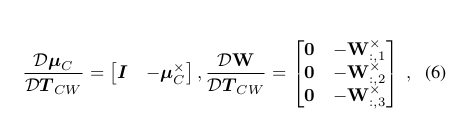

In [323]:
# mu_cam = np.array([3., 4., 5., 1.])
mu_cam = np.array([3.7011, 3.1835, 5.1154, 1.0000])
dmuC_dTcw_paper = np.hstack((np.eye(3),-hat_operator(mu_cam)))
print("dmuC_dTcw_paper:\n",dmuC_dTcw_paper)

dmuC_dTcw_paper:
 [[ 1.      0.      0.     -0.      5.1154 -3.1835]
 [ 0.      1.      0.     -5.1154 -0.      3.7011]
 [ 0.      0.      1.      3.1835 -3.7011 -0.    ]]


## Jac from se3_exp function

In [313]:
func_MU_I(vec)

xi: 
 tensor([[0., -0., 0., 1.],
        [0., 0., -0., 1.],
        [-0., 0., 0., 1.],
        [0., 0., 0., 0.]], grad_fn=<StackBackward0>)
Expm True value T_cw: 
 tensor([[1., 0., 0., 1.],
        [0., 1., 0., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]], grad_fn=<LinalgMatrixExpBackward0>)
mu_cam:  tensor([3., 4., 5., 1.], grad_fn=<MvBackward0>)
mu_I:  tensor([0.6000, 0.8000, 1.0000], grad_fn=<DivBackward0>)
dmuI_dmuC: 
 tensor([[ 0.2000,  0.0000, -0.1200,  0.0000],
        [ 0.0000,  0.2000, -0.1600,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]])
mu_I:  tensor([0.6000, 0.8000, 1.0000], grad_fn=<DivBackward0>)


(tensor([0.6000, 0.8000, 1.0000], grad_fn=<DivBackward0>),
 tensor([3., 4., 5., 1.], grad_fn=<MvBackward0>))

In [314]:
mu_w_tensor

tensor([2., 3., 4., 1.], requires_grad=True)

## Jac with Expm true value

In [315]:
func_MU_I(vec)

xi: 
 tensor([[0., -0., 0., 1.],
        [0., 0., -0., 1.],
        [-0., 0., 0., 1.],
        [0., 0., 0., 0.]], grad_fn=<StackBackward0>)
Expm True value T_cw: 
 tensor([[1., 0., 0., 1.],
        [0., 1., 0., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]], grad_fn=<LinalgMatrixExpBackward0>)
mu_cam:  tensor([3., 4., 5., 1.], grad_fn=<MvBackward0>)
mu_I:  tensor([0.6000, 0.8000, 1.0000], grad_fn=<DivBackward0>)
dmuI_dmuC: 
 tensor([[ 0.2000,  0.0000, -0.1200,  0.0000],
        [ 0.0000,  0.2000, -0.1600,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]])
mu_I:  tensor([0.6000, 0.8000, 1.0000], grad_fn=<DivBackward0>)


(tensor([0.6000, 0.8000, 1.0000], grad_fn=<DivBackward0>),
 tensor([3., 4., 5., 1.], grad_fn=<MvBackward0>))

In [316]:
F.jacobian(func_MU_I, (vec)) #dmuI_dTcw

xi: 
 tensor([[0., -0., 0., 1.],
        [0., 0., -0., 1.],
        [-0., 0., 0., 1.],
        [0., 0., 0., 0.]], grad_fn=<StackBackward0>)
Expm True value T_cw: 
 tensor([[1., 0., 0., 1.],
        [0., 1., 0., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]], grad_fn=<LinalgMatrixExpBackward0>)
mu_cam:  tensor([3., 4., 5., 1.], grad_fn=<MvBackward0>)
mu_I:  tensor([0.6000, 0.8000, 1.0000], grad_fn=<DivBackward0>)
dmuI_dmuC: 
 tensor([[ 0.2000,  0.0000, -0.1200,  0.0000],
        [ 0.0000,  0.2000, -0.1600,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]])
mu_I:  tensor([0.6000, 0.8000, 1.0000], grad_fn=<DivBackward0>)


(tensor([[ 0.2000,  0.0000, -0.1200, -0.4200,  1.2000, -0.7000],
         [ 0.0000,  0.2000, -0.1600, -1.4600,  0.4000,  0.5000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]),
 tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  4.5000, -3.5000],
         [ 0.0000,  1.0000,  0.0000, -4.5000,  0.0000,  2.5000],
         [ 0.0000,  0.0000,  1.0000,  3.5000, -2.5000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]))

## Jac with Expm's 1st order approx value

In [147]:
func_MU_I(vec)

xi: 
 tensor([[0., -0., 0., 1.],
        [0., 0., -0., 1.],
        [-0., 0., 0., 1.],
        [0., 0., 0., 0.]], grad_fn=<StackBackward0>)
Expm 1st order Approx value T_cw: 
 tensor([[1., 0., 0., 1.],
        [0., 1., 0., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]], grad_fn=<AddBackward0>)
mu_cam:  tensor([3., 4., 5., 1.], grad_fn=<MvBackward0>)
mu_I:  tensor([0.6000, 0.8000, 1.0000], grad_fn=<DivBackward0>)


(tensor([0.6000, 0.8000, 1.0000], grad_fn=<DivBackward0>),
 tensor([3., 4., 5., 1.], grad_fn=<MvBackward0>))

In [148]:
F.jacobian(func_MU_I, (vec)) #dmuI_dTcw

xi: 
 tensor([[0., -0., 0., 1.],
        [0., 0., -0., 1.],
        [-0., 0., 0., 1.],
        [0., 0., 0., 0.]], grad_fn=<StackBackward0>)
Expm 1st order Approx value T_cw: 
 tensor([[1., 0., 0., 1.],
        [0., 1., 0., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]], grad_fn=<AddBackward0>)
mu_cam:  tensor([3., 4., 5., 1.], grad_fn=<MvBackward0>)
mu_I:  tensor([0.6000, 0.8000, 1.0000], grad_fn=<DivBackward0>)


(tensor([[ 0.2000,  0.0000, -0.1200, -0.3600,  1.0400, -0.6000],
         [ 0.0000,  0.2000, -0.1600, -1.2800,  0.3200,  0.4000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]),
 tensor([[ 1.,  0.,  0.,  0.,  4., -3.],
         [ 0.,  1.,  0., -4.,  0.,  2.],
         [ 0.,  0.,  1.,  3., -2.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.]]))

# Jac with Expm's 2nd order approx value

In [150]:
func_MU_I(vec)

xi: 
 tensor([[0., -0., 0., 1.],
        [0., 0., -0., 1.],
        [-0., 0., 0., 1.],
        [0., 0., 0., 0.]], grad_fn=<StackBackward0>)
Expm 2nd order Approx value T_cw: 
 tensor([[1., 0., 0., 1.],
        [0., 1., 0., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]], grad_fn=<AddBackward0>)
mu_cam:  tensor([3., 4., 5., 1.], grad_fn=<MvBackward0>)
mu_I:  tensor([0.6000, 0.8000, 1.0000], grad_fn=<DivBackward0>)


(tensor([0.6000, 0.8000, 1.0000], grad_fn=<DivBackward0>),
 tensor([3., 4., 5., 1.], grad_fn=<MvBackward0>))

In [151]:
F.jacobian(func_MU_I, (vec)) #dmuI_dTcw

xi: 
 tensor([[0., -0., 0., 1.],
        [0., 0., -0., 1.],
        [-0., 0., 0., 1.],
        [0., 0., 0., 0.]], grad_fn=<StackBackward0>)
Expm 2nd order Approx value T_cw: 
 tensor([[1., 0., 0., 1.],
        [0., 1., 0., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]], grad_fn=<AddBackward0>)
mu_cam:  tensor([3., 4., 5., 1.], grad_fn=<MvBackward0>)
mu_I:  tensor([0.6000, 0.8000, 1.0000], grad_fn=<DivBackward0>)


(tensor([[ 0.2000,  0.0000, -0.1200, -0.4200,  1.2000, -0.7000],
         [ 0.0000,  0.2000, -0.1600, -1.4600,  0.4000,  0.5000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]),
 tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  4.5000, -3.5000],
         [ 0.0000,  1.0000,  0.0000, -4.5000,  0.0000,  2.5000],
         [ 0.0000,  0.0000,  1.0000,  3.5000, -2.5000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]))

# Jac with Expm's 3rd order approx value

In [91]:
func_MU_I(vec)

xi: 
 tensor([[0., -0., 0., 1.],
        [0., 0., -0., 1.],
        [-0., 0., 0., 1.],
        [0., 0., 0., 0.]], grad_fn=<StackBackward0>)
Expm 3rd order Approx value T_cw: 
 tensor([[1., 0., 0., 1.],
        [0., 1., 0., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]], grad_fn=<AddBackward0>)
mu_cam:  tensor([3., 4., 5., 1.], grad_fn=<MvBackward0>)
mu_I:  tensor([0.6000, 0.8000, 1.0000], grad_fn=<DivBackward0>)


(tensor([0.6000, 0.8000, 1.0000], grad_fn=<DivBackward0>),
 tensor([3., 4., 5., 1.], grad_fn=<MvBackward0>))

In [92]:
F.jacobian(func_MU_I, (vec)) #dmuI_dTcw

xi: 
 tensor([[0., -0., 0., 1.],
        [0., 0., -0., 1.],
        [-0., 0., 0., 1.],
        [0., 0., 0., 0.]], grad_fn=<StackBackward0>)
Expm 3rd order Approx value T_cw: 
 tensor([[1., 0., 0., 1.],
        [0., 1., 0., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]], grad_fn=<AddBackward0>)
mu_cam:  tensor([3., 4., 5., 1.], grad_fn=<MvBackward0>)
mu_I:  tensor([0.6000, 0.8000, 1.0000], grad_fn=<DivBackward0>)


(tensor([[ 0.2000,  0.0000, -0.1200, -0.4200,  1.2000, -0.7000],
         [ 0.0000,  0.2000, -0.1600, -1.4600,  0.4000,  0.5000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]),
 tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  4.5000, -3.5000],
         [ 0.0000,  1.0000,  0.0000, -4.5000,  0.0000,  2.5000],
         [ 0.0000,  0.0000,  1.0000,  3.5000, -2.5000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]))

# Jacobian of the 2D Cov matrix

In [324]:
def func_COV_I(vec):
    I43 = torch.eye(4,3,requires_grad=True, dtype=torch.float32)
    I34 = torch.eye(3,4,requires_grad=True, dtype=torch.float32)
    
    zero = torch.zeros((1), requires_grad=True, dtype=torch.float32)
    xi = torch.stack([
    torch.stack([torch.tensor(0.0), -vec[5],  vec[4],  vec[0]]),
    torch.stack([vec[5],  torch.tensor(0.0), -vec[3],  vec[1]]),
    torch.stack([-vec[4], vec[3],  torch.tensor(0.0),  vec[2]]),
    torch.zeros(4)  # Last row
    ])
    xi.requires_grad_(True)
    print("xi: \n",xi)

    # This is the true value of matrix exponential
    T_cw = torch.matrix_exp(xi)    
    print('Expm True value T_cw: \n', T_cw)

    def compute_W_from_vec(vec_):
        print("Inside compute_W_from_vec")
        I43_ = torch.eye(4,3,requires_grad=True, dtype=torch.float32)
        I34_ = torch.eye(3,4,requires_grad=True, dtype=torch.float32)
        
        zero_ = torch.zeros((1), requires_grad=True, dtype=torch.float32)
        xi_ = torch.stack([
        torch.stack([torch.tensor(0.0), -vec_[5],  vec_[4],  vec_[0]]),
        torch.stack([vec_[5],  torch.tensor(0.0), -vec_[3],  vec_[1]]),
        torch.stack([-vec_[4], vec_[3],  torch.tensor(0.0),  vec_[2]]),
        torch.zeros(4)  # Last row
        ])
        xi_.requires_grad_(True)
        # print("xi: \n",xi_)
    
        # This is the true value of matrix exponential
        T_cw_ = torch.matrix_exp(xi_)
        # T_cw_ = torch.eye(4,4, requires_grad=True, dtype=torch.float32)+ xi_
        W = torch.matmul(I34_,torch.matmul(T_cw_, I43_))
        print("Returning from compute_W_from_vec, T_cw: \n", T_cw_)
        
        return W

    
    dW_dTcw = F.jacobian(compute_W_from_vec, (vec))
    print("dW_dTcw:")
    print(dW_dTcw.reshape(9,6))
    
    
    
    mu_cam = torch.matmul(T_cw, mu_w_tensor)
    print('mu_cam: ', mu_cam)

    def compute_J(mu_cam):
        J = torch.stack([
            torch.cat([torch.tensor([1., 0.]), -mu_cam[0:1]/mu_cam[2:3]]),
            torch.cat([torch.tensor([0., 1.]), -mu_cam[1:2]/mu_cam[2:3]]),
            ])
        J = J/mu_cam[2:3]
        return J
        
    J = compute_J(mu_cam)
    
    # print("Proj jac:\n",J)
    print("dJ_dmu_c: \n", F.jacobian(compute_J, (mu_cam)))
    
    def compute_cov_I(J):

        def compute_W(T_cw):
            W = torch.matmul(I34,torch.matmul(T_cw, I43))
            return W
            
        W = compute_W(T_cw)
        
        def compute_with_W(W):
                
            JW = torch.matmul(J,W)
            cov_I = torch.matmul(JW,torch.matmul(cov_3D_tensor,JW.transpose(1,0)))
            return cov_I
        
        dcovI_dW = F.jacobian(compute_with_W, (W))
        print("dcov_I_dW: ")
        print(dcovI_dW.reshape(4,9))

        print("dcovI_dT_cw Second term: \n", torch.matmul(dcovI_dW.reshape(4,9),dW_dTcw.reshape(9,6)))

        return compute_with_W(W)
    
    
    dcovI_dJ = F.jacobian(compute_cov_I, (J)).reshape(4,6)
    print("dcovI_dJ: \n",dcovI_dJ)

    # print("dJ_dmu_c: \n", F.jacobian(compute_J, (mu_cam)))    
    
    return compute_cov_I(J)

In [325]:
func_COV_I(vec)

xi: 
 tensor([[ 0.0000, -0.4534,  0.4534,  1.0000],
        [ 0.4534,  0.0000, -0.4534,  1.0000],
        [-0.4534,  0.4534,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], grad_fn=<StackBackward0>)
Expm True value T_cw: 
 tensor([[ 0.8047, -0.3106,  0.5059,  1.0000],
        [ 0.5059,  0.8047, -0.3106,  1.0000],
        [-0.3106,  0.5059,  0.8047,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]],
       grad_fn=<LinalgMatrixExpBackward0>)
Inside compute_W_from_vec
Returning from compute_W_from_vec, T_cw: 
 tensor([[ 0.8047, -0.3106,  0.5059,  1.0000],
        [ 0.5059,  0.8047, -0.3106,  1.0000],
        [-0.3106,  0.5059,  0.8047,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]],
       grad_fn=<LinalgMatrixExpBackward0>)
dW_dTcw:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0149, -0.4157, -0.4157],
        [ 0.0000,  0.0000,  0.0000,  0.2723,  0.2723, -0.8434],
        [ 0.0000,  0.0000,  0.0000,  0.1434,  0.8285,  0.1434],
        [ 0.0000,  0.0000,  0.000

tensor([[ 0.0077, -0.0036],
        [-0.0036,  0.0522]], grad_fn=<MmBackward0>)

In [320]:
F.jacobian(func_COV_I, (vec))

xi: 
 tensor([[0., -0., 0., 1.],
        [0., 0., -0., 1.],
        [-0., 0., 0., 1.],
        [0., 0., 0., 0.]], grad_fn=<StackBackward0>)
Expm True value T_cw: 
 tensor([[1., 0., 0., 1.],
        [0., 1., 0., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]], grad_fn=<LinalgMatrixExpBackward0>)
Inside compute_W_from_vec
Returning from compute_W_from_vec, T_cw: 
 tensor([[1., 0., 0., 1.],
        [0., 1., 0., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]], grad_fn=<LinalgMatrixExpBackward0>)
dW_dTcw:
tensor([[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]])
mu_cam:  tensor([3., 4., 5., 1.], grad_fn=<MvBackward0>)
dJ_dmu_c: 
 tensor([[[ 0.0000,  0.0000, -0.0400,  0.0000],

tensor([[[ 0.0384,  0.0000, -0.0333, -0.0685,  0.0256, -0.0544],
         [ 0.0176,  0.0192, -0.0406, -0.1006,  0.0576, -0.0456]],

        [[ 0.0176,  0.0192, -0.0406, -0.1006,  0.0576, -0.0456],
         [ 0.0000,  0.0352, -0.0563, -0.1795,  0.1152,  0.0560]]])